In [2]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from tqdm import tqdm
from PIL import Image

In [3]:
# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 18}
plt.rc('font', **font_mapping)

In [ ]:
sphere = trimesh.creation.icosphere(subdivisions=10, radius=1.0)

In [43]:
# Create a scene with the sphere
scene = trimesh.Scene([sphere])

In [ ]:
# Visualize the scene
scene.show()

In [4]:
folder = 'spheres/'
file = 'sphere_testing.txt'

In [5]:
class DataLog:
    def __init__(self, camera_pos, camera_look_at, frame_time, processed_points):
        self.camera_pos = camera_pos
        self.camera_look_at = camera_look_at
        self.frame_time = frame_time
        self.processed_points = processed_points
        
        # positions to float
        self.camera_pos = [float(x) for x in self.camera_pos]
        self.camera_look_at = [float(x) for x in self.camera_look_at]
        self.direction = np.array(self.camera_look_at) - np.array(self.camera_pos)
        self.direction = self.direction / np.linalg.norm(self.direction)

In [ ]:
def read_logs(filename):
    logs = []

    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for line_i in range(0, len(lines), 4):
            camera_pos = lines[line_i].split('(')[1].split(')')[0].split(',')
            camera_look_at = lines[line_i + 1].split('(')[1].split(')')[0].split(',')
            frame_time = float(lines[line_i + 2].split(':')[1])
            num_processed_points = int(lines[line_i + 3].split(':')[1])
            
            logs.append(DataLog(camera_pos, camera_look_at, frame_time, num_processed_points))
            
    return logs

def get_metrics(logs, silent=False):
    frames = len(logs)
    avg_frame_time = 1000.0 / np.mean([log.frame_time for log in logs])
    max_frame_time = 1000.0 / np.max([log.frame_time for log in logs])
    min_frame_time = 1000.0 / np.min([log.frame_time for log in logs])
    avg_processed_points = np.mean([log.processed_points for log in logs])
    max_processed_points = np.max([log.processed_points for log in logs])
    min_processed_points = np.min([log.processed_points for log in logs])
    
    if not silent:
        print('Number of frames:', frames)
        print('Average frame time:', avg_frame_time)
        print('Maximum frame time:', max_frame_time)
        print('Minimum frame time:', min_frame_time)
        print('Average number of processed points:', avg_processed_points)
        print('Maximum number of processed points:', max_processed_points)
        print('Minimum number of processed points:', min_processed_points)
        
    return frames, avg_frame_time, max_frame_time, min_frame_time, avg_processed_points, max_processed_points, min_processed_points

In [6]:
logs = read_logs(folder + file)
get_metrics(logs)

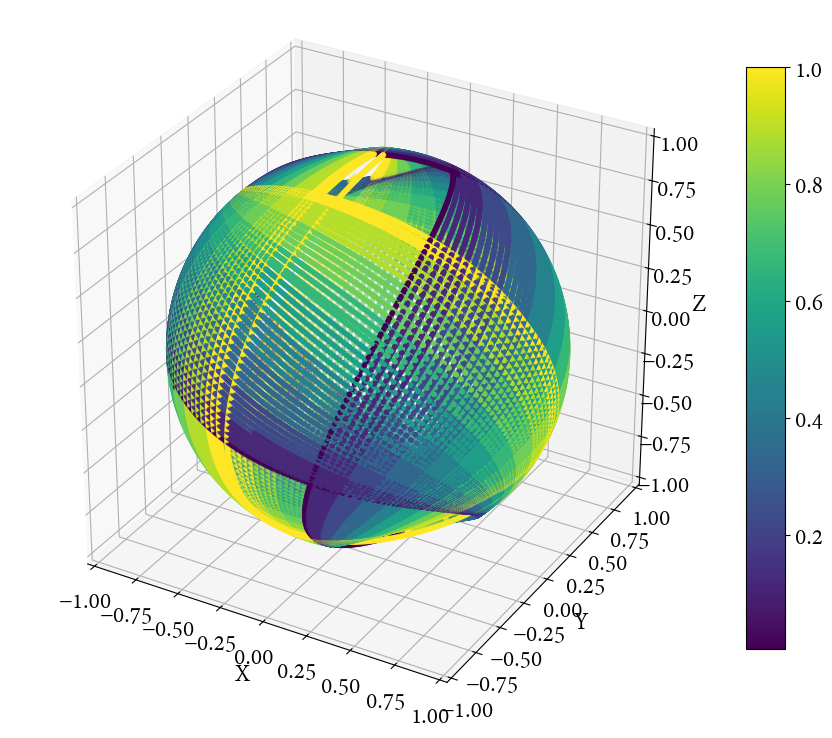

In [16]:
# plot all the camera directions as points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# random_log = np.random.choice(logs, 3000)

# colour logs according to frame time
frame_times = np.array([log.frame_time for log in logs])
frame_times = (frame_times - np.min(frame_times)) / (np.max(frame_times) - np.min(frame_times))
frame_times = plt.cm.viridis(frame_times)

ax.scatter([log.direction[0] for log in logs], [log.direction[1] for log in logs], [log.direction[2] for log in logs], c=frame_times, s=10)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_aspect('equal')

# show legend 
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(frame_times), vmax=np.max(frame_times)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.05, aspect=15)

plt.show()

100%|██████████| 79107/79107 [00:00<00:00, 144474.30it/s]


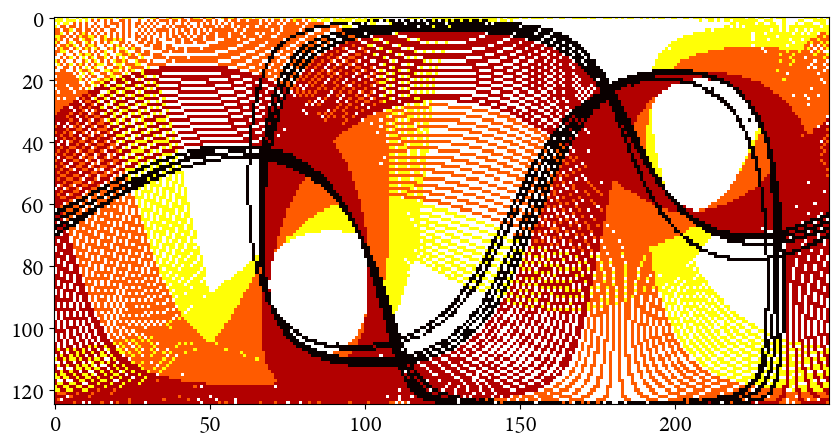

(125, 250, 3)


In [10]:
# build texture from the log directions
res_x, res_y = 250, 125
texture = np.zeros((res_y, res_x, 1), dtype=np.uint16)

# fill with minimum frame_ratio
texture.fill(1000.0 / np.min([log.frame_time for log in logs]))

for log in tqdm(logs):
    x = int((log.direction[0] + 1) * res_x / 2)
    y = int((log.direction[1] + 1) * res_y / 2)
    
    # find angle of x, z direction
    angle = np.arctan2(log.direction[2], log.direction[0])
    if angle < 0:
        angle += 2 * np.pi
    
    x = int(angle * res_x / (2 * np.pi))
    
    texture[y, x] = 1000.0 / log.frame_time
    
# plot the texture
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.imshow(texture[:, :, 0], cmap='hot', interpolation='nearest')
plt.show()
    
# save texture
texture = texture / np.max(texture) * 255
texture = texture.astype(np.uint8)
texture = np.repeat(texture, 3, axis=2)
print(texture.shape)

# save
texture = Image.fromarray(texture)
texture.save('sphere_texture.png')

In [ ]:
# open image
image = Image.open('sphere_texture.png')

# load sphere
sphere = trimesh.creation.icosphere(subdivisions=4, radius=1.0)

# assign texture
sphere.visual = trimesh.visual.TextureVisuals(uv=image, image=image)

# create scene
scene = trimesh.Scene([sphere])

# show scene
scene.show()

In [ ]:
# Generate points of an sphere manually with a given radius
radius = 1.0
center = np.array([0, 0, 0])

# icosahedron vertices
vertices = []

# subdvisions 
h, v = 10, 5

# golden ratio
phi = (1 + np.sqrt(5)) / 2

# add vertices
vertices.append(np.array([0, 1, phi]))
vertices.append(np.array([0, -1, phi]))
vertices.append(np.array([0, 1, -phi]))
vertices.append(np.array([0, -1, -phi]))

vertices.append(np.array([1, phi, 0]))
